In [136]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime, timedelta
from scipy.stats import ttest_1samp

In [163]:
def get_data(
    noaa_path=r"C:\Users\edwar\OneDrive\Desktop\noaa_disasters.csv",
    min_cost_millions=1000,
    event_types=['Tropical Cyclone', 'Drought', 'Winter Storm', 'Cold Wave', 'Flooding'],
    lookback_years=5,
    plot_prices=True
):
    end_date = datetime.today()
    start_date = end_date - timedelta(days=365*lookback_years)

    # Download Henry Hub Futures
    hh = yf.download("NG=F", start=start_date, end=end_date)
    if isinstance(hh.columns, pd.MultiIndex):
        hh.columns = hh.columns.map('_'.join)

    close_col = [c for c in hh.columns if 'Close' in c][0]
    hh = hh[[close_col]].rename(columns={close_col: 'Close'})
    hh['Returns'] = hh['Close'].pct_change()
    hh['RollingMean'] = hh['Returns'].rolling(20).mean()
    hh = hh.dropna()

    # Load NOAA disaster data
    noaa = pd.read_csv(noaa_path, skiprows=2)
    noaa.columns = noaa.columns.str.strip()
    noaa['Begin Date'] = pd.to_datetime(noaa['Begin Date'].astype(str), format='%Y%m%d', errors='coerce')
    noaa['End Date'] = pd.to_datetime(noaa['End Date'].astype(str), format='%Y%m%d', errors='coerce')

    # Filter relevant events
    weather_events = noaa[
        (noaa['Begin Date'] >= start_date) &
        (noaa['Begin Date'] <= end_date) &
        (noaa['Disaster'].isin(event_types)) &
        (noaa['CPI-Adjusted Cost'] >= min_cost_millions)
    ].copy()

    weather_events['Event Date'] = weather_events['Begin Date']
    weather_events = weather_events.sort_values('Event Date').reset_index(drop=True)

    # Plot LNG futures prices with weather event overlays
    if plot_prices:
        plt.figure(figsize=(14,6))
        plt.plot(hh.index, hh['Close'], color='blue', label='LNG Futures Price')
        
        # Overlay events
        colors = {
            'Tropical Cyclone': 'red',
            'Drought': 'orange',
            'Winter Storm': 'green',
            'Cold Wave': 'purple',
            'Flooding': 'cyan'
        }
        for dtype in event_types:
            event_dates = weather_events[weather_events['Disaster'] == dtype]['Event Date']
            for date in event_dates:
                plt.axvline(date, color=colors.get(dtype, 'black'), linestyle='--', alpha=0.7, label=dtype)
        
        # Avoid duplicate legend entries
        handles, labels = plt.gca().get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        plt.legend(by_label.values(), by_label.keys())
        
        plt.title(f"Henry Hub LNG Futures Prices ({lookback_years} Years) with Weather Events")
        plt.xlabel("Date")
        plt.ylabel("Price (USD/MMBtu)")
        plt.grid(True)
        plt.show()

    return hh, weather_events



In [164]:
def create_event_windows(hh, weather_events, pre=5, event=3, post=7):
    hh.index = pd.to_datetime(hh.index)
    hh = hh.dropna(subset=['Returns'])
    windows = []

    for _, row in weather_events.iterrows():
        event_date = row['Event Date']

        # Nearest trading day
        if event_date not in hh.index:
            event_date = hh.index[hh.index.get_indexer([event_date], method='nearest')[0]]

        pos = hh.index.get_loc(event_date)

        pre_index = hh.index[max(pos-pre,0):pos] if pre>0 else []
        event_index = hh.index[pos:pos+event+1]
        post_index = hh.index[pos+event+1:pos+event+1+post] if post>0 else []

        windows.append({
            'Event Date': event_date,
            'Pre': hh.loc[pre_index, 'Returns'],
            'Event': hh.loc[event_index, 'Returns'],
            'Post': hh.loc[post_index, 'Returns'],
            'Disaster': row['Disaster'],
            'Cost': row['CPI-Adjusted Cost']
        })

    return windows

# -------------------------------
# 2. Align AR arrays robustly
# -------------------------------
def align_ar(ar, target_length, pad_left=True):
    if len(ar) > target_length:
        return ar[-target_length:] if pad_left else ar[:target_length]
    elif len(ar) < target_length:
        pad_width = target_length - len(ar)
        if pad_left:
            return np.pad(ar, (pad_width, 0), 'constant', constant_values=np.nan)
        else:
            return np.pad(ar, (0, pad_width), 'constant', constant_values=np.nan)
    else:
        return ar



In [165]:
def event_study_by_type(hh, windows, pre=5, event=3, post=7, n_bootstrap=1000, alpha=0.05):
    hh.index = pd.to_datetime(hh.index)
    hh = hh.dropna(subset=['Returns'])
    disaster_types = set(w['Disaster'] for w in windows)
    summary = []

    plt.figure(figsize=(12,7))

    for dtype in disaster_types:
        type_windows = [w for w in windows if w['Disaster']==dtype]

        aligned_ars = []
        max_pre, max_event, max_post = pre, event, post

        for w in type_windows:
            pre_ar = align_ar((w['Pre'] - hh['RollingMean'].reindex(w['Pre'].index)).values, max_pre, pad_left=True)
            event_ar = align_ar((w['Event'] - hh['RollingMean'].reindex(w['Event'].index)).values, max_event, pad_left=False)
            post_ar = align_ar((w['Post'] - hh['RollingMean'].reindex(w['Post'].index)).values, max_post, pad_left=False)

            aligned_ars.append(np.concatenate([pre_ar, event_ar, post_ar]))

        ar_matrix = pd.DataFrame(aligned_ars)
        aar = ar_matrix.mean(skipna=True)
        caar = aar.cumsum()

        # Bootstrap CI
        boot_caar = np.zeros((n_bootstrap, len(aar)))
        for i in range(n_bootstrap):
            sample = ar_matrix.sample(frac=1, replace=True)
            boot_caar[i] = sample.mean(skipna=True).cumsum()
        lower = np.percentile(boot_caar, 100*alpha/2, axis=0)
        upper = np.percentile(boot_caar, 100*(1-alpha/2), axis=0)

        x_range = np.arange(len(caar)) - max_pre  # dynamic x-axis
        plt.plot(x_range, caar, marker='o', label=dtype)
        plt.fill_between(x_range, lower, upper, alpha=0.2)

        pre_caar = caar[:max_pre].iloc[-1] if max_pre>0 else 0
        event_caar = caar[max_pre:max_pre+max_event].iloc[-1] if max_event>0 else 0
        post_caar = caar[-max_post:].iloc[-1] if max_post>0 else 0

        summary.append({
            'Disaster': dtype,
            'Num_Events': len(type_windows),
            'Pre-event CAAR': pre_caar,
            'Event CAAR': event_caar,
            'Post-event CAAR': post_caar,
            'Pre-event effect': 'Increase' if pre_caar>0 else 'Decrease',
            'Event effect': 'Increase' if event_caar>0 else 'Decrease',
            'Post-event effect': 'Increase' if post_caar>0 else 'Decrease'
        })

    plt.axvline(0, color='black', linestyle='--', label='Event Date')
    plt.title('CAAR by Disaster Type (Pre, Event, Post)')
    plt.xlabel('Days Relative to Event')
    plt.ylabel('Cumulative Average Abnormal Return (CAAR)')
    plt.grid(True)
    plt.legend()
    plt.show()

    return pd.DataFrame(summary)


C:\Users\edwar\AppData\Local\Temp\ipykernel_11340\2505530658.py:12: FutureWarning: YF.download() has changed argument auto_adjust default to True
  hh = yf.download("NG=F", start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


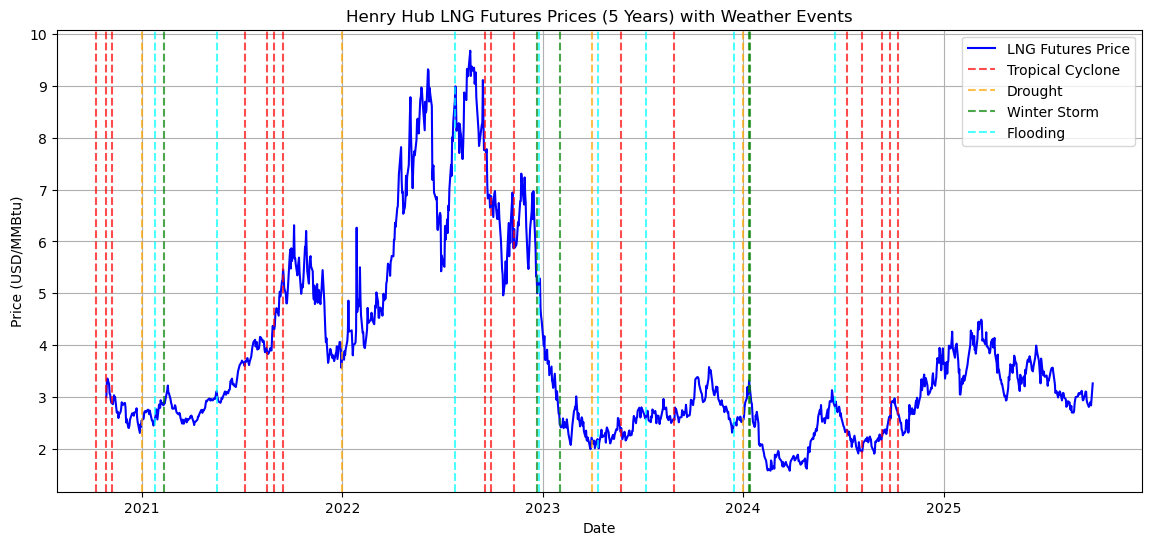

Loaded 1238 trading days and 34 disaster events.


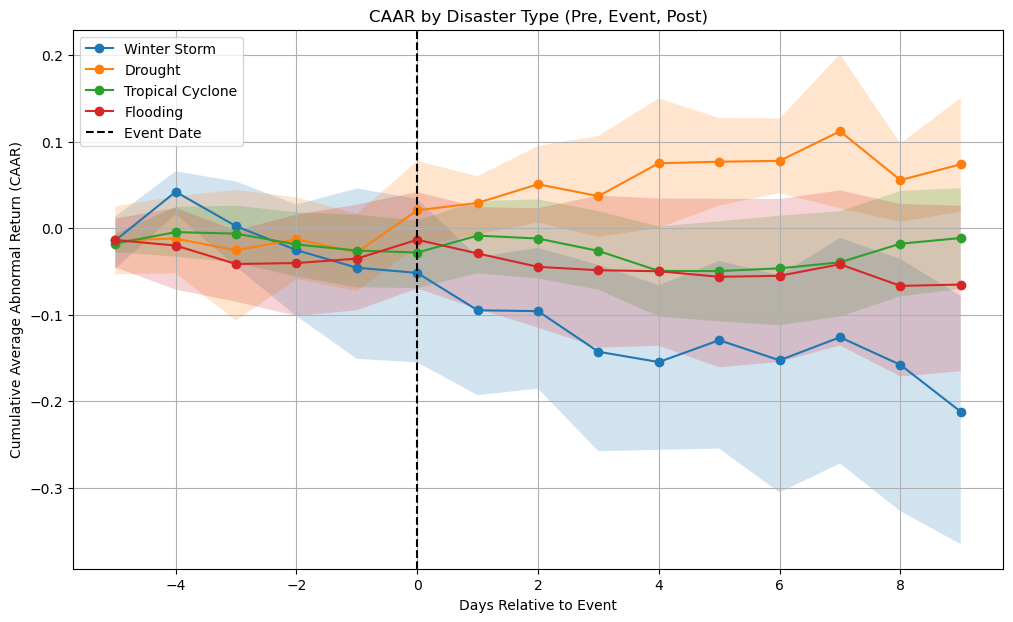


Event Study Summary:
           Disaster  Num_Events  Pre-event CAAR  Event CAAR  Post-event CAAR  \
0      Winter Storm           5       -0.045749   -0.095988        -0.212276   
1           Drought           4       -0.028035    0.050790         0.073812   
2  Tropical Cyclone          17       -0.025865   -0.011996        -0.011386   
3          Flooding           8       -0.035281   -0.044745        -0.065236   

  Pre-event effect Event effect Post-event effect  
0         Decrease     Decrease          Decrease  
1         Decrease     Increase          Increase  
2         Decrease     Decrease          Decrease  
3         Decrease     Decrease          Decrease  


In [166]:
hh, weather_events = get_data()  # assuming your get_data() is defined
print(f"Loaded {len(hh)} trading days and {len(weather_events)} disaster events.")

windows = create_event_windows(hh, weather_events)
summary = event_study_by_type(hh, windows)
print("\nEvent Study Summary:")
print(summary)